## PJM On-Peak Basis Forecast Model

In this project, we aim to construct a Machine Learning model that forecasts the PJM Day-Ahead on-peak basis. After 5 PM on any given day, suppose we have the following information:
- The RT basis before 5 PM
- The whole day DA basis for tomorrow
- The load forecast for the day after tomorrow. 

With this input data, we will train a model that predicts the on-peak basis for the day after tomorrow. Currently, the goal is to setup a baseline model that can be improved down the road.

## Data Exploration and Preprocessing

The input dataset is extremely large and convoluted. Before we begin training the model, we need to experiment with some approaches to aggregate the input data and reduce the dimensionality of the feature space. Here are some ideas:
- Reduce the input hourly data by averaging together offpeak (0-7) and on-peak hours (8-23) separately 
- Only consider columns AQ-AS of the raw data, which correspond to Southern, Western, and RTO Combined averages.
- Shift the data so that the inputs align correctly with their predicted values.

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

input_path = "./Input Data/"
da_basis = pd.read_excel(os.path.join(input_path, "basis_forecast.xlsx"), skiprows=1, usecols="A:I")
rt_basis = pd.read_excel(os.path.join(input_path, "basis_forecast.xlsx"), skiprows=1, usecols="K:T")
load_forecast = pd.read_excel(os.path.join(input_path, "basis_forecast.xlsx"), skiprows=1, usecols=[21, 42, 43, 44])

rt_basis.rename(columns={"Date/Time.1": "Date/Time"}, inplace=True)
load_forecast.rename(columns={"Date/Time.2": "Date/Time"}, inplace=True)


In [42]:
def extract_date_hour(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts date and hour information from the first column of a DataFrame containing
    datetime values in the format '%m/%d/%Y %H:%M' and adds them as new columns at the
    beginning of the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame with a datetime column.

    Returns:
        pd.DataFrame: A modified DataFrame with 'Date' and 'Hour' columns inserted at
        the beginning, derived from the datetime values in the first column.
    """
    first_column = df["Date/Time"]

    df.insert(0, "Hour", pd.to_datetime(first_column, format='%m/%d/%Y %H:%M').dt.hour) 
    df.insert(0, "Date", pd.to_datetime(first_column, format='%m/%d/%Y %H:%M').dt.date) 

    df = df.drop(columns=["Date/Time"])
    return df

def onpeak_averages(df: pd.DataFrame, max_hour=23) -> pd.DataFrame:
    return df[df['Hour'].between(8, max_hour)].groupby('Date').mean()

In [43]:
da_basis = extract_date_hour(da_basis)
rt_basis = extract_date_hour(rt_basis)
load_forecast = extract_date_hour(load_forecast)

da_basis = onpeak_averages(da_basis)
rt_basis = onpeak_averages(rt_basis)
load_forecast = onpeak_averages(load_forecast)

In [44]:
filtered_da_basis = da_basis.drop(columns=["Hour", "WESTERN HUB (DALMP) Average"])
filtered_rt_basis = rt_basis.drop(columns=["Hour", "WESTERN HUB (RTLMP) Average", "DOM (RTLMP) Average"])
filtered_load = load_forecast.drop(columns=["Hour"])

filtered_da_basis

,EDGEMOOR 13 KV HAYRD5 (DALMP ) - WESTERN HUB (DALMP ),STEEL CITY 4CC (DALMP ) - WESTERN HUB (DALMP ),PEACHBOT 22 KV UNIT02 (DALMP ) - WESTERN HUB (DALMP ),DPL (DALMP ) - WESTERN HUB (DALMP ),PPL (DALMP ) - WESTERN HUB (DALMP ),PECO (DALMP ) - WESTERN HUB (DALMP ),PPL (DALMP ) - PECO (DALMP )
Date,,,,,,,
2023-03-02,-6.954243,-5.481743,-6.172368,-6.499994,-4.002253,-6.911082,2.908829
2023-03-03,-5.699907,-4.164907,-5.024282,-5.370517,-2.665954,-5.550337,2.884383
2023-03-04,-6.891482,-5.338982,-5.978357,-6.159625,-4.013960,-6.782493,2.768533
2023-03-05,-5.150585,-3.925585,-4.559335,-4.720920,-3.195029,-5.111387,1.916358
2023-03-06,-10.824295,-7.633045,-10.318670,-10.586316,-5.572445,-10.567663,4.995217
...,...,...,...,...,...,...,...
2023-08-28,-16.828261,-15.680761,-16.435136,-15.948193,-16.357958,-16.524892,0.166935
2023-08-29,-12.468041,-18.844916,-12.204291,-9.414580,-12.397914,-11.955101,-0.442812
2023-08-30,-8.507473,-8.989348,-8.597473,-0.234348,-7.481840,-7.672713,0.190873


In [45]:
filtered_rt_basis

,EDGEMOOR 13 KV HAYRD5 (RTLMP ) - WESTERN HUB (RTLMP ),STEEL CITY 4CC (RTLMP ) - WESTERN HUB (RTLMP ),PEACHBOT 22 KV UNIT02 (RTLMP ) - WESTERN HUB (RTLMP ),DPL (RTLMP ) - WESTERN HUB (RTLMP ),PPL (RTLMP ) - WESTERN HUB (RTLMP ),PECO (RTLMP ) - WESTERN HUB (RTLMP ),DOM (RTLMP ) - WESTERN HUB (RTLMP )
Date,,,,,,,
2023-03-02,-7.310962,-5.685337,-6.514712,-6.940381,-4.377942,-7.144502,0.687699
2023-03-03,-29.448966,-22.135841,-25.302091,-31.015898,-16.370919,-30.220666,3.580380
2023-03-04,-5.001312,-3.686312,-4.424437,-4.824496,-2.902074,-4.818943,0.747545
2023-03-05,-2.958059,-2.371184,-2.684309,-2.640678,-2.219544,-2.846816,0.547339
2023-03-06,-16.255971,-11.250346,-15.352221,-16.770486,-7.970276,-15.699204,1.471185
...,...,...,...,...,...,...,...
2023-08-28,-10.298857,-8.493232,-9.436982,-9.772216,-7.304510,-10.001455,2.200515
2023-08-29,-2.735554,-2.433679,-2.603679,-1.741496,-2.058443,-2.350258,0.659566
2023-08-30,-2.644051,-2.308426,-2.439676,-1.821970,-1.881078,-2.372914,1.120785


In [46]:
filtered_load

,SOUTHERN REGION (BIDCLOSE_LOAD_FORECAST) Average,WESTERN REGION (BIDCLOSE_LOAD_FORECAST) Average,RTO COMBINED (BIDCLOSE_LOAD_FORECAST) Average
Date,,,
2023-03-02,12160.8750,46643.5625,88391.7500
2023-03-03,13030.6875,47585.5000,92872.9375
2023-03-04,11616.0000,43177.9375,83955.9375
2023-03-05,11899.8125,42125.0625,82131.6875
2023-03-06,12661.8125,46351.1250,89498.1250
...,...,...,...
2023-08-28,15111.6250,52011.9375,102796.1875
2023-08-29,16250.8125,52445.1250,105658.6250
2023-08-30,16540.3750,48907.6875,104289.6250


<Figure size 1200x600 with 0 Axes>

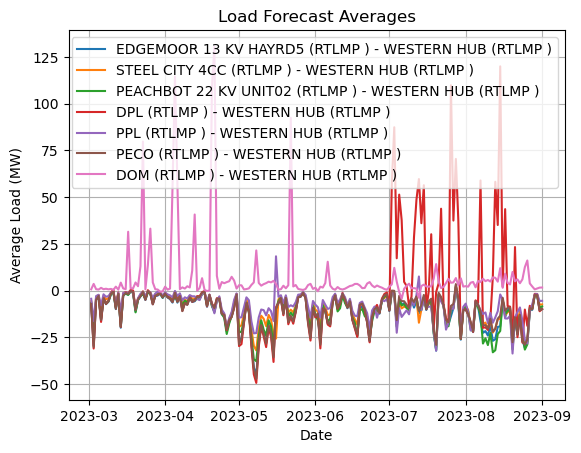